# Infos

- Pre-process using an 8–30 Hz filter and a notch filter
- Sampled at 125 Hz

HEALTHY:
- S4
  - No Baseline CSV
- S3
  - Not ordered tasks. Random between T2 and T0. Also, only BASE1T0 available.
		
UNHEALTHY:
- S1 / S2 / S3 
  - Channel locations in TSV are greater than columns (for example) in S1E1 etc.

# Imports

In [1]:
import os
import random
import zipfile

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Check if we have CUDA support

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print('Cuda available: {}'.format(torch.cuda.is_available()))
    print("GPU: " + torch.cuda.get_device_name(torch.cuda.current_device()))
    print("Total memory: {:.1f} GB".format((float(torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)))))
    print("===================================================")
else:
    device = torch.device("cpu")
    print('Cuda not available, so using CPU. Please consider switching to a GPU runtime before running the notebook!')

Cuda available: True
GPU: NVIDIA GeForce RTX 3060
Total memory: 12.0 GB


# Dataset

## Download from Drive

In [ ]:
downloadDataset = True

if(downloadDataset):
    EEG_Dataset_URL = 'https://drive.google.com/uc?id=' + '1Ijm2rxaGksYbnl1AQIYdConiNMrA1N0R' + '&export=download&confirm=t'
    EEG_zip_name = "EEG_Dataset_Final.zip"
    extracted_dir = "Dataset/"

    gdown.download(EEG_Dataset_URL, EEG_zip_name, quiet=False)

    # Create a ZipFile object and open the ZIP file
    with zipfile.ZipFile(EEG_zip_name, 'r') as zip_ref:
        # Extract all the contents to the specified directory
        zip_ref.extractall(extracted_dir)

    print(f"Files extracted to {extracted_dir}")

    os.remove(EEG_zip_name)

## Helper functions

In [60]:
# First, get the electrodes positions for each subject starting from the TSV files
# This is needed to correctly name the column in the Pandas Dataframe that will be created later
def get_electrodes_positions(mode = 'Unhealthy', mapping: dict = None):
    selected_files = []

    for _, values in mapping.items():
        for value in values:
            for run in range(1, 13):  # Assuming runs go from 1 to 13
                filename = f"Dataset/{mode}/{value}_task-motion_run-{run}_electrodes.tsv"
                if os.path.exists(filename):
                    selected_files.append(filename)
                    break  # Break the loop once a file is found for the subject
                else:
                    filename = f"Dataset/{mode}/{value}_task-motorimagery_run-{run}_electrodes.tsv"
                    if os.path.exists(filename):
                        selected_files.append(filename)
                        break
            if filename in selected_files:
                break  # Break the outer loop if a file is found for the subject
    return selected_files

def reorder_files(file_list, mode = 'Unhealthy', subject = 'S1'):
    # Extract the file index from each element
    indices = [int(file.split('E')[1].split('.')[0]) for file in file_list]

    # Create a mapping of indices to files
    index_to_file = dict(zip(indices, file_list))

    # Reorder the files based on the desired order
    if(mode == 'Unhealthy'):
        desired_order = [1, 2, 3]
    elif(mode == 'Healthy' and subject == 'S3'):
        desired_order = [1, 2, 4, 3]
    elif(mode == 'Healthy' and subject == 'S6'):
        desired_order = [3, 1, 2, 4]
    else:
        desired_order = [2, 3, 4, 1]

    return [index_to_file[index] for index in desired_order]

# For Healty Dataset, we need to get the corresponding mapping between
# the runs, labels, and the subject
def get_final_csv(mode = 'Unhealthy', subject = 'S1', subject_to_filter = None, electrodes_list = None):
    # Various lists to store the dataframes
    dfs = []
    file_paths = []

    # Get file paths and reorder them
    file_paths = [f"Dataset/{mode}/{file}" for file in os.listdir(f"Dataset/{mode}/") if file.startswith(subject) and file.endswith(".csv")]
    file_paths = reorder_files(file_paths, mode=mode, subject=subject)

    # Channel locations file
    channel_locations = [selected_file for selected_file in electrodes_list if str(subject_to_filter[0]) or str(subject_to_filter[1]) in selected_file][0]

    # Read channel locations CSV
    channel_dataframe = pd.read_csv(channel_locations, sep='\t')
    channel_column = np.append(channel_dataframe.iloc[:, 0].values, 'Label')  # Append label column

    # Read each CSV file into a DataFrame and append it to the list
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        dfs.append(df)

    # Concatenate all DataFrames in the list into a single DataFrame
    result_df = pd.concat(dfs, ignore_index=True)
    result_df.columns = channel_column

    return result_df

def convert_labels(df: pd.DataFrame):
    label_encoder = LabelEncoder() # Use LabelEncoder to convert string labels to numerical classes
    df['Label'] = label_encoder.fit_transform(df.iloc[:, -1].values) # Update the DataFrame with the encoded labels
    return df

## Get electrodes positions

In [61]:
mapping = {
    "S1": ["sub-001", "sub-01"],
    "S2": ["sub-003", "sub-02"],
    "S3": ["sub-009", "sub-03"],
    "S4": ["sub-022", "sub-04"],
    "S5": ["sub-039", "sub-05"],
    "S6": ["sub-040", "sub-06"],
    "S7": ["sub-058", "sub-07"],
}

unhealthy_electrodes = get_electrodes_positions(mode='Unhealthy', mapping=mapping)
healthy_electrodes = get_electrodes_positions(mode='Healthy', mapping=mapping)

print("Unhealthy electrodes:")
for electrode in unhealthy_electrodes:
    print(electrode)
print("---------------------")
print("Healthy electrodes:")
for electrode in healthy_electrodes:
    print(electrode)
print("---------------------")

Unhealthy electrodes:
Dataset/Unhealthy/sub-01_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-02_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-03_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-04_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-05_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-06_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-07_task-motorimagery_run-1_electrodes.tsv
---------------------
Healthy electrodes:
Dataset/Healthy/sub-001_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-003_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-009_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-022_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-039_task-motion_run-5_electrodes.tsv
Dataset/Healthy/sub-040_task-motion_run-3_electrodes.tsv
Dataset/Healthy/sub-058_task-motion_run-2_electrodes.tsv
---------------------


## Get the corresponding CSV for each subject

In [89]:
# Get all the CSVs for each subject and concatenate them into a single DataFrame
# This is done for both Healthy and Unhealthy datasets, but for now it's only used for the Healthy one
# ------------------
# Unhealthy dataset is not used because it's not clear how to map the electrodes correctly
# ------------------

dfs = []

for key, value in mapping.items():
    # print("-----------------------------------------------")
    # print("Subject: ", key)
    # print("-----------------------------------------------")
    dataframe_sub = get_final_csv(mode='Healthy', subject = key, subject_to_filter = value, electrodes_list=healthy_electrodes)
    #dataframe_sub = get_final_csv(mode='Unhealthy', subject = key, subject_to_filter = value, electrodes_list=unhealthy_electrodes) -> Bugged
    # Display the first few rows of the DataFrame to inspect the data
    #print(F"Labels example before LabelEncoder: {dataframe_sub.iloc[0, -1]}")
    dataframe_sub = convert_labels(df=dataframe_sub)
    #print(F"Labels example after LabelEncoder: {dataframe_sub.iloc[0, -1]}")
    #print("-----------------------------------------------")
    #print(F"Features example:\n{dataframe_sub.iloc[0, :-1].values} ")
    #print(F"Dataframe shape: {dataframe_sub.shape}")
    #print("-----------------------------------------------")
    dfs.append(dataframe_sub)

final_df = pd.concat(dfs, ignore_index=True)
print(F"Labels example after LabelEncoder: {final_df.iloc[0, -1]}")
print("-----------------------------------------------")
print(F"Features example:\n{final_df.iloc[0, :-1].values} ")
print("-----------------------------------------------")
print(F"Dataframe shape: {final_df.shape}")
print("-----------------------------------------------")

Labels example after LabelEncoder: 0
-----------------------------------------------
Features example:
[-22.32802   -28.60501     6.88227    29.89963    -6.402574  -21.38284
 -48.43559   -36.35843   -19.95552    -7.680849    7.486315    2.688819
 -16.92748   -21.11188   -27.53305   -28.93034   -10.3112      0.274484
  -4.528653  -19.98537   -21.87354   -63.16142   -53.93449   -37.41989
 -82.35215   -75.31709   -44.00559   -46.4395    -70.87901   -44.68941
 -47.12579   -16.29449   -33.76904   -36.90424   -45.13832   -59.83243
 -72.44492   -33.07028   -52.34872   -82.62269   -65.12589   -40.77698
 -56.42884    -0.6641415 -59.04758   -34.11868   -56.20611   -35.23507
  -0.4604792  -6.716199  -19.1434    -15.99165   -28.54176   -29.21788
 -29.93014   -48.6239    -40.99841   -23.9235    -15.0966    -29.9198
 -42.53465   -10.20088    -0.7355843  20.63075  ] 
-----------------------------------------------
Dataframe shape: (13097, 65)
-----------------------------------------------


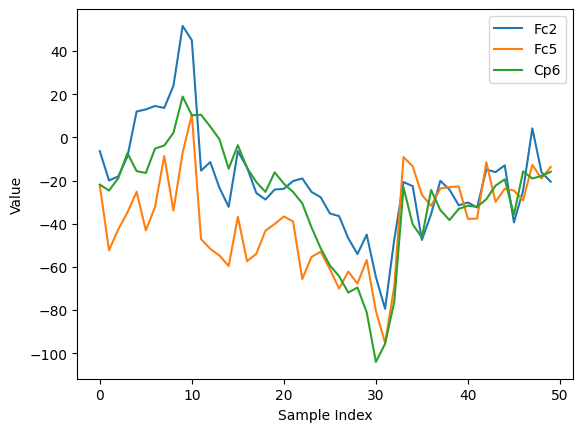

In [85]:
# Plotting example
fc2_electrode = 'Fc2'
fc5_electrode = 'Fc5'
cp6_electrode = 'Cp6'
len_signal = 50

# Plot the selected feature for class 0 and class 1 on the same plot
plt.plot(final_df[fc2_electrode][:len_signal], label=f'{fc2_electrode}', linestyle='-')
plt.plot(final_df[fc5_electrode][:len_signal], label=f'{fc5_electrode}', linestyle='-')
plt.plot(final_df[cp6_electrode][:len_signal], label=f'{cp6_electrode}', linestyle='-')

plt.xlabel('Sample Index')
plt.ylabel("Value")
plt.legend()
plt.show()

## Get the actual Dataloader

In [90]:
class CustomDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame):
        self.data = dataframe.values.astype('float32')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Features (until last column)
        features = torch.tensor(self.data[idx, :-1], dtype=torch.float32)

        # Label (last column)
        label = torch.tensor(self.data[idx, -1], dtype=torch.float32)

        return features, label

In [92]:
scaler = MinMaxScaler()
labels = final_df.iloc[:, -1]

# Scale the features between 0 and 1 and concatenate them with the labels
df_scaled = pd.DataFrame(scaler.fit_transform(final_df.iloc[:, :-1]))

finalDf = pd.concat([df_scaled, labels], axis=1)
finalDf = finalDf.dropna()  # Remove rows with NaN values

assert not finalDf.isna().any().any(), "finalDf contains NaN values"

train_df, test_df = train_test_split(finalDf, test_size=0.2, random_state=2047315)

# Create custom datasets and data loaders
train_dataset = CustomDataset(pd.DataFrame(train_df))
test_dataset = CustomDataset(pd.DataFrame(test_df))

batch_size = 8 # Adjust as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of samples in test dataset: {len(test_dataset)}")
print("------------------------------------------------------")
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")
print("------------------------------------------------------")
batch = next(iter(train_loader))
print(f"Shape of batch (X): {batch[0].shape}")
print(f"Shape of batch (y): {batch[1].shape}")

Number of samples in train dataset: 10477
Number of samples in test dataset: 2620
------------------------------------------------------
Number of batches in train loader: 1310
Number of batches in test loader: 328
------------------------------------------------------
Shape of batch (X): torch.Size([8, 64])
Shape of batch (y): torch.Size([8])


# Model

In [93]:
class CVAE(nn.Module):
    def __init__(self, num_features, latent_dim, output_dim, condition_dim):
        super(CVAE, self).__init__()

        # Encoder
        #self.fc1 = nn.Linear(num_features + condition_dim, 512)
        self.fc1 = nn.Linear(num_features, 64, device=device)
        self.fc2 = nn.Linear(64, 32, device=device)

        self.fc_mu = nn.Linear(32, latent_dim, device=device)
        self.fc_logvar = nn.Linear(32, latent_dim, device=device)

        # Decoder
        #.fc3 = nn.Linear(latent_dim + condition_dim, 256)
        self.fc3 = nn.Linear(latent_dim, 32, device=device)
        self.fc4 = nn.Linear(32, 64, device=device)

        self.fc_output = nn.Linear(64, output_dim, device=device)

    def encode(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc_mu(x), self.fc_logvar(x)

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc_output(z))

    # Take the mean (mu - μ) and log-variance (log(2)log(σ2)) produced by the Encoder 
    # and generates a latent code z using the reparameterization trick.
    # This process ensures that the sampling operation is differentiable,
    # enabling the use of backpropagation during training.
    def reparameterize(self, mu, logvar):
        # The standard deviation (std) is calculated as the 
        # exponential of half of the log-variance.
        # This ensures that std is positive.
        std = torch.exp(0.5 * logvar)

        # Generates random noise with the same shape as the computed standard deviation.
        # This noise is sampled from a normal distribution with mean 0 and standard deviation 1.
        eps = torch.randn_like(std)
        return mu + eps * std # μ + σ ⊙ ϵ

    def forward(self, x, condition=None):
        #x = torch.cat([x, condition], dim=1)    # Add the condition to Encoder - CVAE ---> TODO
        
        mu, logvar = self.encode(x)             # Encoding

        z = self.reparameterize(mu, logvar)     # Re-parametrization | Latent variable

        #z = torch.cat([z, condition], dim=1)    # Add the condition to Decoder - CVAE ---> TODO
        reconstructed_x = self.decode(z)        # Decoding
        return reconstructed_x, mu, logvar

In [94]:
num_features = batch[0].shape[1]    # 64 -> Number of features in the CSV
latent_dim = 16                     # Latent space dimension
output_dim = batch[0].shape[1]      # Output dimension (same as input for reconstruction)
condition_dim = 1                   # Dimension of the conditional variable (4 classes)

cvae = CVAE(num_features, latent_dim, output_dim, condition_dim)
cvae = cvae.to(device=device)
print(cvae)

CVAE(
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc_mu): Linear(in_features=32, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=64, bias=True)
  (fc_output): Linear(in_features=64, out_features=64, bias=True)
)


In [96]:
# Example usage
num_epochs = 50

# Define your loss function and optimizer
criterion = nn.MSELoss()  # You can choose a different loss function based on your task

# Define your optimizer
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)  # You can adjust the learning rate based on your needs

# Training loop
for epoch in tqdm(range(num_epochs), desc=F"Epochs (Train)", leave=True):

    # Train CVAE
    cvae.train()

    losses = []  # Store the loss of each batch in this list

    for i, (x, labels) in enumerate(train_loader):

        # We need to move to the GPU
        x = x.to(device=device)
        labels = labels.to(device=device)

        # Forward pass
        reconstructed_data, mu, logvar = cvae(x, None)

        # Assuming reconstructed_x is the output of your CVAE, input_x is the input data
        reconstruction_loss = criterion(reconstructed_data, x)

        # KL Divergence
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        loss = reconstruction_loss + kl_divergence

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    # Compute the mean and standard deviation of the losses
    mean_loss = np.mean(losses)
    std_loss = np.std(losses)

    if(epoch % 5 == 0):
        print(f"Epoch {epoch} | Mean Loss = {mean_loss:.3f} | Std Loss = {std_loss:.3f}")

Epochs (Train):   2%|▏         | 1/50 [00:05<04:18,  5.28s/it]

Epoch 0 | Mean Loss = 0.009 | Std Loss = 0.005


Epochs (Train):  12%|█▏        | 6/50 [00:32<03:58,  5.42s/it]

Epoch 5 | Mean Loss = 0.009 | Std Loss = 0.005


Epochs (Train):  22%|██▏       | 11/50 [00:59<03:31,  5.43s/it]

Epoch 10 | Mean Loss = 0.009 | Std Loss = 0.005


Epochs (Train):  32%|███▏      | 16/50 [01:26<03:04,  5.42s/it]

Epoch 15 | Mean Loss = 0.009 | Std Loss = 0.005


Epochs (Train):  42%|████▏     | 21/50 [01:53<02:37,  5.42s/it]

Epoch 20 | Mean Loss = 0.009 | Std Loss = 0.005


Epochs (Train):  52%|█████▏    | 26/50 [02:20<02:10,  5.43s/it]

Epoch 25 | Mean Loss = 0.009 | Std Loss = 0.005


Epochs (Train):  62%|██████▏   | 31/50 [02:47<01:42,  5.42s/it]

Epoch 30 | Mean Loss = 0.009 | Std Loss = 0.005


Epochs (Train):  72%|███████▏  | 36/50 [03:15<01:15,  5.43s/it]

Epoch 35 | Mean Loss = 0.009 | Std Loss = 0.005


Epochs (Train):  82%|████████▏ | 41/50 [03:42<00:48,  5.44s/it]

Epoch 40 | Mean Loss = 0.009 | Std Loss = 0.005


Epochs (Train):  92%|█████████▏| 46/50 [04:09<00:21,  5.41s/it]

Epoch 45 | Mean Loss = 0.009 | Std Loss = 0.005


Epochs (Train): 100%|██████████| 50/50 [04:31<00:00,  5.42s/it]


Generated samples:
	tensor([[0.3945, 0.4789, 0.4731, 0.4835, 0.4003, 0.4495, 0.5227, 0.4943, 0.5508,
         0.5177, 0.4717, 0.5506, 0.5043, 0.4904, 0.5259, 0.5022, 0.5118, 0.4333,
         0.4609, 0.4970, 0.4707, 0.3855, 0.3913, 0.4042, 0.4214, 0.3482, 0.4080,
         0.3700, 0.4125, 0.3941, 0.4217, 0.3481, 0.4124, 0.3596, 0.4036, 0.3920,
         0.4521, 0.3848, 0.5556, 0.4334, 0.3884, 0.4996, 0.5319, 0.4840, 0.5420,
         0.4129, 0.4434, 0.5612, 0.4375, 0.5053, 0.5130, 0.5247, 0.5174, 0.4022,
         0.5020, 0.4247, 0.5460, 0.5249, 0.5201, 0.5670, 0.4519, 0.4890, 0.5719,
         0.5091]], device='cuda:0') | Shape: torch.Size([1, 64])
True samples:
	tensor([[0.4014, 0.4851, 0.4854, 0.5085, 0.4245, 0.4586, 0.5368, 0.4718, 0.5564,
         0.5145, 0.4824, 0.5582, 0.5080, 0.5097, 0.5273, 0.4994, 0.5157, 0.4344,
         0.4814, 0.4745, 0.5027, 0.4863, 0.5007, 0.5226, 0.4913, 0.4185, 0.4446,
         0.4310, 0.4728, 0.4478, 0.4441, 0.3465, 0.4058, 0.3528, 0.3960, 0.3786,
         

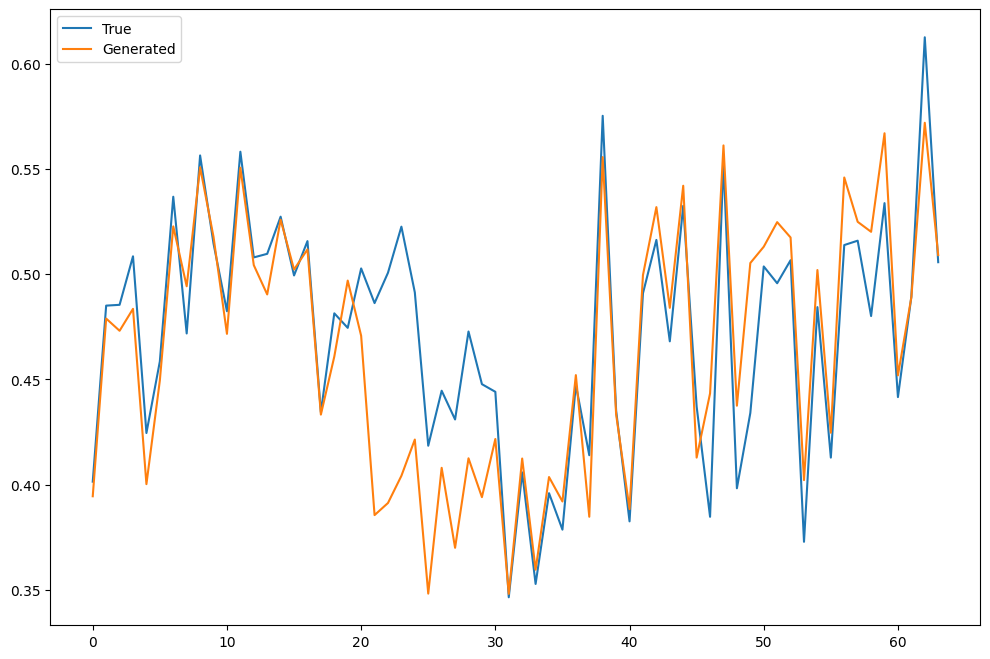

In [106]:
# Assuming cvae is your trained CVAE model
# Assuming latent_dim is the dimensionality of the latent space
num_samples = 1
cvae.eval()
randomNoise = False

outputList = []
outputListTrue = []

if(randomNoise):
    with torch.no_grad():
        # Generate random latent vectors from a normal distribution
        y_true = torch.rand(1, 10, device=device)

        # Repeat the condition tensor for each generated sample
        # Pass the latent vectors through the decoder
        generated_samples, _, _ = cvae(y_true)

        y = generated_samples.detach().cpu().numpy()[0, :]
        y_true = y_true.detach().cpu().numpy()[0, :]
else: # Test loader
    with torch.no_grad():
        test_iter = iter(test_loader)
        random_batch_idx = random.randint(0, len(test_loader) - 1)
        for batch_idx, (x, _) in enumerate(test_loader):
            if batch_idx == random_batch_idx:
                x = x.to(device=device)
                x = x[0, :].unsqueeze(0)  # Get just one sample and pass it to the network
                x_hat, _, _ = cvae(x)
                outputList.append(x_hat)
                outputListTrue.append(x)
                break

        # Example usage:
        generated_samples_torch = torch.vstack(outputList)
        true_samples_torch = torch.vstack(outputListTrue)
        print(F"Generated samples:\n\t{generated_samples_torch} | Shape: {generated_samples_torch.shape}")
        print(F"True samples:\n\t{true_samples_torch} | Shape: {true_samples_torch.shape}")

        # We take the 6th sample from the generated samples and print all the channels
        y = generated_samples_torch.detach().cpu().numpy()[0, :]
        y_true = true_samples_torch.detach().cpu().numpy()[0, :]

plt.figure(figsize=(12, 8))
plt.plot(y_true, label='True')
plt.plot(y, label='Generated')
plt.legend()
plt.show()